In [1]:
# Estas líneas sirven para que el código se actualice automáticamente.
# Así, si se realiza un cambio en los paquetes importados, no se tiene que reiniciar todo el notebook para ver reflejados los cambios.
# Es como tener un "refresco" automático para el programa.

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
# Ejemplo del sistema fuzzy aplicado al dataset de las orquídeas (Iris)
# ========================================================
# Importación de bibliotecas necesarias para probar el código

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Establece el estilo de los gráficos en "whitegrid" (fondo blanco con cuadrícula). Seaborn es una biblioteca para visualizaciones.
sns.set(style="whitegrid")

In [3]:
# Cargar el dataset de las orquídeas (Iris)
# =========================================
# Esta función hace lo siguiente:
# 1. Carga un conjunto de datos llamado "Iris" que contiene información sobre flores.
# 2. Convierte esos datos en una tabla fácil de usar (llamada DataFrame).
# 3. Añade una columna a la tabla que indica el tipo de flor (especie).
# 4. Muestra en la pantalla:
#    - Cuántas filas y columnas tiene la tabla.
#    - Las primeras 5 filas de la tabla para que veas cómo son los datos.
#    - Un resumen estadístico de los datos numéricos.
# 5. Finalmente, la función devuelve la tabla y una lista con los nombres de
#    las columnas que representan las características de las flores.

def cargar_datos():
    """
    Carga el dataset de Iris y lo prepara para su uso
    """
    print("Cargando el dataset de las orquídeas (Iris)...")
    iris = load_iris()
    df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

    # Agrega una columna 'target' al DataFrame, que contiene la clasificación
    # numérica de cada flor (0, 1, o 2).
    df['target'] = iris.target
    df['species'] = df['target'].map({
        0: 'Iris-setosa',
        1: 'Iris-versicolor',
        2: 'Iris-virginica'
    })

    print("Dimensiones del dataset:", df.shape)
    print("\nPrimeras filas del dataset:")
    print(df.head())

    print("\nEstadísticas descriptivas:")
    print(df.describe())

    return df, iris.feature_names, iris.target_names

In [4]:
# Visualización de los datos
# =========================
# Esta función crea cuatro gráficos, uno para cada medida de las flores (largo y ancho de sépalos y pétalos).
# Cada gráfico muestra barras de diferentes colores, donde cada color representa una especie de Iris,
# y la altura de la barra muestra cuántas flores tienen esa medida en particular.

def visualizar_datos(df):
    """
    Visualiza la distribución de las características de las orquídeas

    Args:
        df (pd.DataFrame): DataFrame con los datos de las flores
    """
    print("\nVisualizando la distribución de las características...")

    plt.figure(figsize=(15, 10))

    # Histogramas de cada característica por especie
    for i, feature in enumerate(df.columns[:4]):
        plt.subplot(2, 2, i+1)
        sns.histplot(data=df, x=feature, hue='species', multiple='stack', palette='viridis', bins=10)
        plt.title(f'Distribución de {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

Cargando el dataset de las orquídeas (Iris)...
Dimensiones del dataset: (150, 6)

Primeras filas del dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target      species  
0       0  Iris-setosa  
1       0  Iris-setosa  
2       0  Iris-setosa  
3       0  Iris-setosa  
4       0  Iris-setosa  

Estadísticas descriptivas:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866

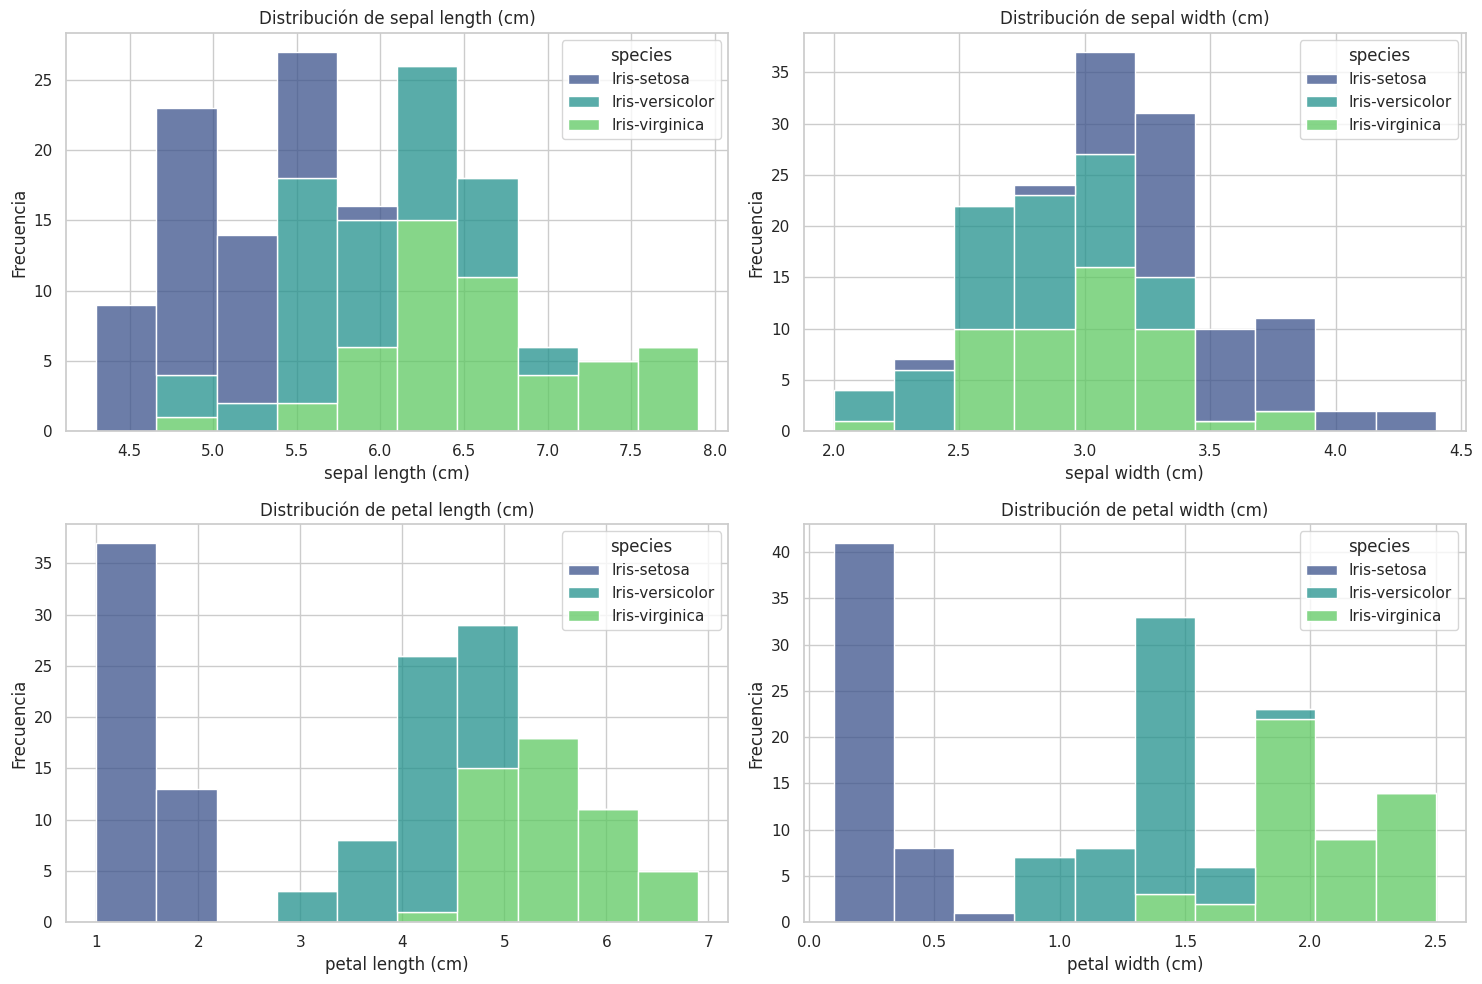

In [5]:
# Carga y visualiza los datos de las Iris
# =========================
# Llama a la función cargar_datos() para obtener el DataFrame (df) y los nombres de las columnas (feature_names).
# Luego, llama a la función visualizar_datos() pasando el DataFrame para generar las visualizaciones.

# Cargar y explorar los datos
df, feature_names, target_names = cargar_datos()

# Visualizar los datos
visualizar_datos(df)

In [6]:
# Creación del sistema fuzzy
# =========================
# Esta función construye un clasificador de lógica difusa:
# 1. Define variables de entrada para las cuatro medidas de las flores.
# 2. Define la variable de salida que representa la especie de la flor.
# 3. Para cada variable (entrada y salida), crea "funciones de pertenencia" que
#    definen conjuntos difusos como "corto", "medio", "largo".
# 4. Grafica estas funciones de pertenencia.
# 5. Establece reglas que usan lógica difusa (combinaciones de AND, OR) para conectar
#    las variables de entrada con la salida.  Por ejemplo, una regla podría decir:
#    "SI el largo del pétalo es corto Y el ancho del pétalo es estrecho, ENTONCES
#    la especie es setosa".
# 6. Crea un objeto "ControlSystem" y un "ControlSystemSimulation" a partir de
#    las reglas, que se usarán para hacer predicciones.
# 7. Devuelve el simulador.

def crear_sistema_fuzzy(feature_names):
    """
    Crea un sistema de lógica difusa para clasificar orquídeas
    basado en sus características

    Args:
        feature_names (list): Lista de nombres de las características

    Returns:
        ctrl.ControlSystemSimulation: Simulador del sistema fuzzy
    """
    print("\nCreando el sistema fuzzy...")

    # Crear las variables de entrada (antecedentes)
    sepal_length = ctrl.Antecedent(np.arange(4, 8, 0.1), 'sepal_length')
    sepal_width = ctrl.Antecedent(np.arange(2, 5, 0.1), 'sepal_width')
    petal_length = ctrl.Antecedent(np.arange(1, 7, 0.1), 'petal_length')
    petal_width = ctrl.Antecedent(np.arange(0, 3, 0.1), 'petal_width')

    # Crear la variable de salida (consecuente)
    species = ctrl.Consequent(np.arange(0, 3, 0.1), 'species')

    # Definir las funciones de pertenencia para cada variable de entrada
    # Longitud del sépalo
    sepal_length['corto'] = fuzz.trimf(sepal_length.universe, [4, 4, 5.5])
    sepal_length['medio'] = fuzz.trimf(sepal_length.universe, [4.5, 5.5, 6.5])
    sepal_length['largo'] = fuzz.trimf(sepal_length.universe, [6, 7.5, 8])

    # Ancho del sépalo
    sepal_width['estrecho'] = fuzz.trimf(sepal_width.universe, [2, 2, 3])
    sepal_width['medio'] = fuzz.trimf(sepal_width.universe, [2.5, 3, 3.5])
    sepal_width['ancho'] = fuzz.trimf(sepal_width.universe, [3.3, 4.5, 5])

    # Longitud del pétalo
    petal_length['corto'] = fuzz.trimf(petal_length.universe, [1, 1, 2.5])
    petal_length['medio'] = fuzz.trimf(petal_length.universe, [2, 3.5, 5])
    petal_length['largo'] = fuzz.trimf(petal_length.universe, [4.5, 6, 7])

    # Ancho del pétalo
    petal_width['estrecho'] = fuzz.trimf(petal_width.universe, [0, 0, 0.7])
    petal_width['medio'] = fuzz.trimf(petal_width.universe, [0.5, 1.2, 1.8])
    petal_width['ancho'] = fuzz.trimf(petal_width.universe, [1.5, 2.5, 3])

    # Definir las funciones de pertenencia para la variable de salida
    species['setosa'] = fuzz.trimf(species.universe, [0, 0, 0.5])
    species['versicolor'] = fuzz.trimf(species.universe, [0.5, 1, 1.5])
    species['virginica'] = fuzz.trimf(species.universe, [1.5, 2, 2.5])

    # Visualizar las funciones de pertenencia
    sepal_length.view()
    plt.show()
    sepal_width.view()
    plt.show()
    petal_length.view()
    plt.show()
    petal_width.view()
    plt.show()
    species.view()
    plt.show()

    # Definir las reglas fuzzy - incluyendo todas las variables de entrada
    print("\nDefiniendo las reglas fuzzy...")

    # Reglas para Iris Setosa
    rule1 = ctrl.Rule(
        (petal_length['corto'] & petal_width['estrecho']) &
        (sepal_length['corto'] | sepal_length['medio']) &
        (sepal_width['medio'] | sepal_width['ancho']),
        species['setosa']
    )

    # Reglas para Iris Versicolor
    rule2 = ctrl.Rule(
        (petal_length['medio'] & petal_width['medio']) &
        (sepal_length['medio']) &
        (sepal_width['estrecho'] | sepal_width['medio']),
        species['versicolor']
    )

    # Reglas para Iris Virginica
    rule3 = ctrl.Rule(
        (petal_length['largo'] & petal_width['ancho']) &
        (sepal_length['medio'] | sepal_length['largo']) &
        (sepal_width['estrecho'] | sepal_width['medio']),
        species['virginica']
    )

    # Reglas adicionales para mejorar la clasificación
    rule4 = ctrl.Rule(
        (petal_length['medio'] & petal_width['ancho']) &
        (sepal_length['medio'] | sepal_length['largo']) &
        (sepal_width['estrecho']),
        species['virginica']
    )

    rule5 = ctrl.Rule(
        (petal_length['medio'] & petal_width['estrecho']) &
        (sepal_length['medio']) &
        (sepal_width['medio']),
        species['versicolor']
    )

    print("\nReglas definidas!")

    # Crear el sistema de control
    system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
    simulator = ctrl.ControlSystemSimulation(system)

    return simulator

In [7]:
# Evaluar el sistema fuzzy
# =======================
# Esta función hace lo siguiente para evaluar el sistema difuso:
# 1. Divide los datos en un conjunto de entrenamiento (que no se usa directamente
#    aquí, pero es una práctica común) y un conjunto de prueba.
# 2. Para cada flor en el conjunto de prueba:
#    a. Introduce las medidas de la flor en el simulador del sistema difuso.
#    b. Ejecuta el simulador para obtener un valor difuso que representa
#       la especie predicha.
#    c. Convierte ese valor difuso en una etiqueta de clase concreta (0, 1 o 2).
#    d. Imprime las medidas de la flor, la clase real y la clase predicha (para
#       las primeras 5 flores).
# 3. Calcula la precisión del sistema:  el porcentaje de flores en el conjunto
#    de prueba que fueron clasificadas correctamente.
# 4. Muestra un gráfico que representa el resultado del proceso de inferencia
#    difusa (el área bajo la curva defuzzificada).

def evaluar_sistema_fuzzy(simulator, df, feature_names):
    """
    Evalúa el sistema fuzzy con los datos de prueba y visualiza los conjuntos
    de salida y el área final de la variable de salida

    Args:
        simulator (ctrl.ControlSystemSimulation): Simulador del sistema fuzzy
        df (pd.DataFrame): DataFrame con los datos de prueba
        feature_names (list): Lista de nombres de las características
    """
    print("\nEvaluando el sistema fuzzy...")

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X = df[feature_names].values
    y = df['target'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
    print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

    # Clasificar las muestras de prueba
    predictions = []

    for i, sample in enumerate(X_test):
        # Asignar valores a las variables de entrada
        simulator.input['sepal_length'] = sample[0]
        simulator.input['sepal_width'] = sample[1]
        simulator.input['petal_length'] = sample[2]
        simulator.input['petal_width'] = sample[3]

        try:
            # Computar el resultado
            simulator.compute()

            # Obtener la predicción
            predicted_value = simulator.output['species']

            # Convertir el valor flotante a una clase
            if predicted_value < 0.5:
                predicted_class = 0  # Setosa
            elif predicted_value < 1.5:
                predicted_class = 1  # Versicolor
            else:
                predicted_class = 2  # Virginica

            predictions.append(predicted_class)

            # Mostrar detalles para algunas muestras
            if i < 5:
                print(f"\nMuestra {i+1}:")
                print(f"Características: {sample}")
                print(f"Clase real: {y_test[i]} - Predicción: {predicted_class}")
                print(f"Valor fuzzy: {predicted_value}")

        except:
            print(f"Error al procesar la muestra {i+1}")
            predictions.append(-1)  # Valor para indicar error

    # Filtrar las predicciones en caso de errores
    valid_indices = [i for i, pred in enumerate(predictions) if pred != -1]
    valid_predictions = [predictions[i] for i in valid_indices]
    valid_targets = [y_test[i] for i in valid_indices]

    if len(valid_predictions) > 0:
        # Calcular la precisión
        accuracy = sum(1 for i, j in zip(valid_predictions, valid_targets) if i == j) / len(valid_predictions)
        print(f"\nPrecisión del sistema fuzzy: {accuracy:.4f}")
    else:
        print("\nNo se pudieron obtener predicciones válidas para evaluar el sistema")


In [8]:
# Analizar un ejemplo específico
# =============================
# Esta función simula la clasificación de una sola flor Iris:
# 1. Define las medidas de una flor (sépalo y pétalo) como valores fijos.
# 2. Introduce estas medidas en el simulador del sistema difuso.
# 3. Ejecuta la simulación para obtener un valor difuso que representa la especie.
# 4. Convierte el valor difuso en un nombre de especie (Setosa, Versicolor, Virginica).
# 5. Imprime las medidas de la flor, la especie predicha y el valor difuso.
# 6. Muestra un gráfico que representa el proceso de inferencia difusa.
# 7. Incluye un bloque try-except para manejar posibles errores durante la simulación.

def analizar_ejemplo(simulator, ejemplo):
    """
    Analiza un ejemplo específico en detalle

    Args:
        simulator (ctrl.ControlSystemSimulation): Simulador del sistema fuzzy
        ejemplo (dict): Diccionario con las características de la flor
    """
    print("\nAnalizando un ejemplo específico...")

    # Asignar valores a las variables de entrada desde el diccionario
    simulator.input['sepal_length'] = ejemplo['sepal_length']
    simulator.input['sepal_width'] = ejemplo['sepal_width']
    simulator.input['petal_length'] = ejemplo['petal_length']
    simulator.input['petal_width'] = ejemplo['petal_width']

    # Computar el resultado
    try:
        simulator.compute()

        # Obtener la predicción
        predicted_value = simulator.output['species']

        # Convertir el valor flotante a una especie
        if predicted_value < 0.5:
            species_name = "Iris Setosa"
        elif predicted_value < 1.5:
            species_name = "Iris Versicolor"
        else:
            species_name = "Iris Virginica"

        print("\nCaracterísticas de la muestra:")
        print(f"- Longitud del sépalo: {ejemplo['sepal_length']} cm")
        print(f"- Ancho del sépalo: {ejemplo['sepal_width']} cm")
        print(f"- Longitud del pétalo: {ejemplo['petal_length']} cm")
        print(f"- Ancho del pétalo: {ejemplo['petal_width']} cm")

        print(f"\nEspecie predicha: {species_name}")
        print(f"Valor fuzzy: {predicted_value}")

        # Visualizar el área final de la variable de salida
        species.view(sim=simulator)
        plt.show()

    except:
        print("Error al procesar el ejemplo específico")


Creando el sistema fuzzy...


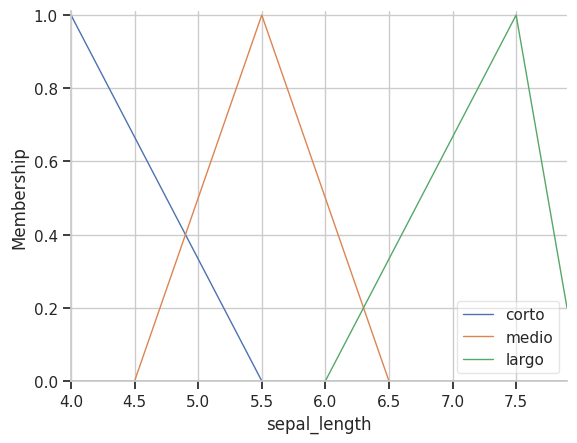

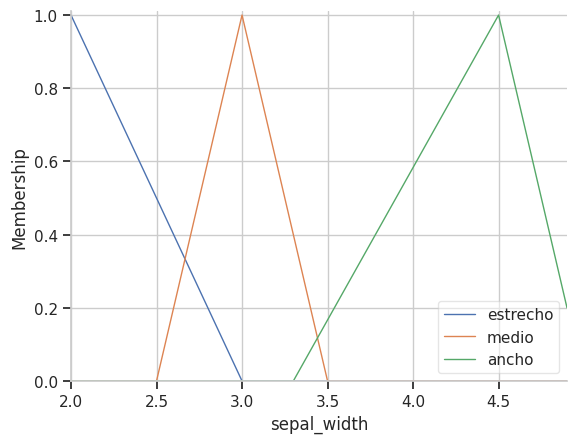

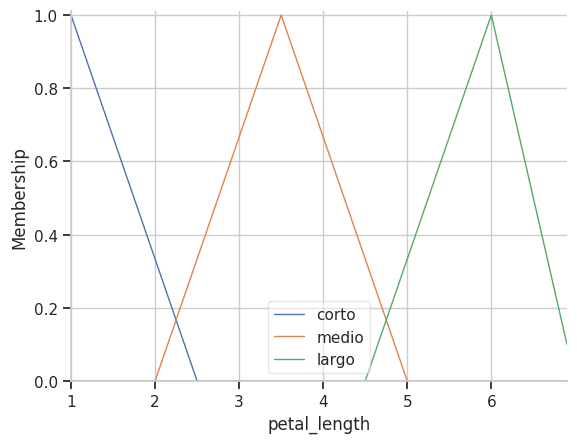

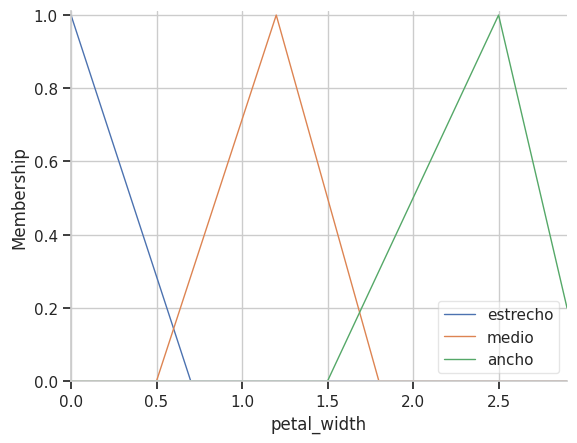

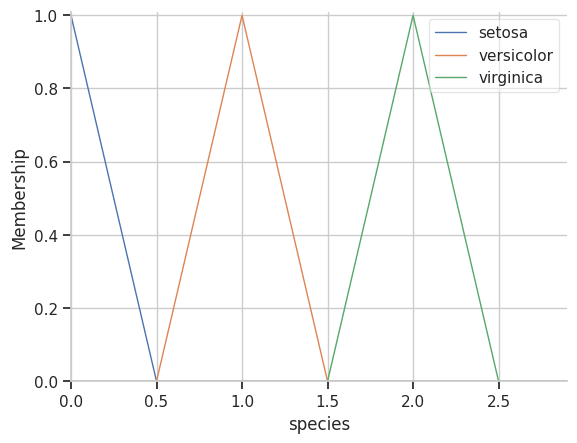


Definiendo las reglas fuzzy...

Reglas definidas!


In [9]:
# Crear el sistema fuzzy
# =======================
# Llama a la función para crear el sistema de inferencia Fuzzy, con las reglas y funciones de pertenencia definidas previamente.
fuzzy_system = crear_sistema_fuzzy(feature_names)

In [10]:
# Evaluar el sistema fuzzy
# =========================
# Como los modelos de inferencia fuzzy no son entrenados sobre los datos, sino
# que contienen el conocimiento transmitido por un experto. Se prueba el rendimiento
# de los mismos sobre un conjunto de prueba.
evaluar_sistema_fuzzy(fuzzy_system, df, feature_names)


Evaluando el sistema fuzzy...
Tamaño del conjunto de entrenamiento: 105 muestras
Tamaño del conjunto de prueba: 45 muestras

Muestra 1:
Características: [6.1 2.8 4.7 1.2]
Clase real: 1 - Predicción: 1
Valor fuzzy: 1.0000000000000002

Muestra 2:
Características: [5.7 3.8 1.7 0.3]
Clase real: 0 - Predicción: 0
Valor fuzzy: 0.20248538011695907

Muestra 3:
Características: [7.7 2.6 6.9 2.3]
Clase real: 2 - Predicción: 2
Valor fuzzy: 1.9999999999999998

Muestra 4:
Características: [6.  2.9 4.5 1.5]
Clase real: 1 - Predicción: 1
Valor fuzzy: 0.9999999999999998
Error al procesar la muestra 5
Error al procesar la muestra 25
Error al procesar la muestra 33
Error al procesar la muestra 43

Precisión del sistema fuzzy: 1.0000


In [11]:
# Analizar un ejemplo específico
# ===================================
# Se prueba un ejemplo, con el fin de observar el proceso de inferencia.

ejemplo = {
    'sepal_length': 5.4,
    'sepal_width': 3.2,
    'petal_length': 3.5,
    'petal_width': 1.5
}

analizar_ejemplo(fuzzy_system, ejemplo)

print("\n¡Análisis fuzzy del dataset de las orquídeas completado!")


Analizando un ejemplo específico...

Características de la muestra:
- Longitud del sépalo: 5.4 cm
- Ancho del sépalo: 3.2 cm
- Longitud del pétalo: 3.5 cm
- Ancho del pétalo: 1.5 cm

Especie predicha: Iris Versicolor
Valor fuzzy: 1.0
Error al procesar el ejemplo específico

¡Análisis fuzzy del dataset de las orquídeas completado!
